# 🏈 The Anticipation Void: Quantifying Zone Manipulation
**Project:** NFL Big Data Bowl Submission  
**Focus:** Ball-in-Air Dynamics & Zone Coverage Manipulation

---

## 1. The Objective
Traditional NFL analytics measure the **result** of a play (EPA, Completion %, YAC). This project aims to measure the **process**—specifically, the creation of open space ("Voids") before the ball is even thrown.

Our goal is to quantify **"Spatial Manipulation"**: How elite Quarterbacks ("Puppeteers") and Route Runners ("Gravity") use their eyes and movement to force defenders out of position, creating a physics-based disadvantage that persists while the ball is in the air.

## 2. The Core Metric: Closing Line Velocity (CLV)
We introduce a new physics-based metric: **Closing Line Velocity (CLV)**.

Instead of measuring simple distance, CLV measures the **Velocity Vector** of the nearest defender relative to the eventual catch point.
* **Negative CLV:** The defender is closing on the catch point (Good Coverage).
* **Positive CLV:** The defender is moving *away* from the catch point (A Void is opening).

$$
CLV = -1 \times (\vec{v}_{defender} \cdot \hat{u}_{ball})
$$

## 3. The Hypothesis: "Pre-Throw Lie, Post-Throw Panic"
This analysis connects **Pre-Throw Manipulation** to **Post-Throw Efficiency**.
We hypothesize that high Pre-Throw CLV (a defender moving the wrong way) results in measurable **Ball-in-Air Inefficiency**:
1.  **Reaction Delay:** Increased time to identify and break toward the ball.
2.  **Path Inefficiency:** Defenders forced to run curved "banana routes" rather than straight lines due to hip orientation.

## 4. Purpose of this Notebook: Scientific Parameter Tuning
To ensure our model is robust and not based on arbitrary "heuristics," we perform Exploratory Data Analysis (EDA) to derive our model parameters from the data distribution itself.

**We will scientifically determine the following inputs:**

1.  **Timeline Thresholds:** How many frames of `post_throw` data exist before tracking cuts off?
    * **So What?** Determining the exact drop-off point ensures we calculate vector efficiency on a standardized time window (e.g., 0.5s vs 1.5s) without dropping valid plays due to missing data.

2.  **Gravity Thresholds:** What speed constitutes "Running a Route" vs. "Standing Still"?
    * **So What?** By finding the speed distribution "valley," we can statistically filter out checkdowns (stationary RBs) to ensure "Gravity" credit is only assigned to active route runners who pull coverage.

3.  **Vision Thresholds:** What is the standard deviation of a defender's head orientation?
    * **So What?** Proving that defender head movement has low variance validates that a specific "Vision Cone" (e.g., 60°) represents a deliberate choice to look at the QB, rather than random scanning.

4.  **Scoring Benchmarks:** What CLV score constitutes the 90th percentile ("Elite")?
    * **So What?** This establishes a baseline for "Significant Manipulation." It ensures our "Puppeteer" leaderboard highlights only exceptional plays where momentum was fully committed in the wrong direction, filtering out minor shuffles.

---

# 2. Theoretical Framework: The Physics Engine

Before tuning parameters, we must define the mathematical "Ground Truth" of our metrics.

### A. Closing Line Velocity (CLV) Formula
**Goal:** Measure if a defender is creating a "Void" (moving away from the catch point).

We treat the interaction as a vector projection problem.
1.  Let $\vec{V}_{def}$ be the defender's velocity vector $(v_x, v_y)$.
2.  Let $\vec{P}_{def}$ be the defender's position and $\vec{P}_{ball}$ be the eventual catch point.
3.  Let $\hat{u}$ be the unit vector pointing from the defender to the catch point:
    $$\hat{u} = \frac{\vec{P}_{ball} - \vec{P}_{def}}{||\vec{P}_{ball} - \vec{P}_{def}||}$$

**The Metric:**
$$CLV = -1 \times (\vec{V}_{def} \cdot \hat{u})$$

* **Logic:** The dot product $(\vec{V}_{def} \cdot \hat{u})$ represents the speed at which the defender is closing the distance.
* **Sign Inversion:** We multiply by $-1$ so that **positive values** represent a "Void" (opening up space) and **negative values** represent "Closing" (good coverage).

---

### B. The "Puppeteer" Vision Cone
**Goal:** Mathematically define "Looking at the Quarterback."

We compare two angles in the 2D plane:
1.  $\theta_{def}$: The defender's physical orientation (0°–360°).
2.  $\theta_{QB}$: The calculated angle of the vector pointing to the QB.
    $$\theta_{QB} = \arctan\left(\frac{y_{QB} - y_{def}}{x_{QB} - x_{def}}\right)$$

**The Condition:**
$$\text{Puppeteer Event} \iff \min(|\theta_{def} - \theta_{QB}|, 360 - |\dots|) < \text{Threshold}$$

* **Hypothesis:** If this condition is met *while* $CLV > 0$ (drifting away), the void is caused by "Eye Manipulation."

---

### C. Ball-In-Air (BIA) Efficiency
**Goal:** Quantify "Panic" (Inefficient movement post-throw).

Instead of measuring distance, we measure **Vector Efficiency**.
For every frame $t$ while the ball is in the air:
1.  $\vec{m}_t$: The unit vector of the defender's *actual* movement direction.
2.  $\vec{i}_t$: The unit vector of the *ideal* path to the ball.

$$\text{Efficiency}_t = \vec{m}_t \cdot \vec{i}_t$$

* **1.0:** Perfect efficiency (running straight at the ball).
* **0.0:** Moving perpendicular to the ball.
* **-1.0:** Running directly away from the ball.

**Panic Score (Normalized):**
We normalize the score so that running directly away from the ball (-1.0 efficiency) equals 100% Panic.

$$
\text{Panic} = \left( \frac{1.0 - \text{Avg\_Efficiency}}{2.0} \right) \times 100
$$

* **0% Panic:** Perfectly efficient ($\text{Efficiency} = 1.0$)
* **50% Panic:** Neutral / Turned Around ($\text{Efficiency} = 0.0$)
* **100% Panic:** Running Wrong Way ($\text{Efficiency} = -1.0$)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed master file
file_path = '../data/processed/master_zone_tracking.csv'
print(f"Loading {file_path}...")
df = pd.read_csv(file_path, low_memory=False)

# CRITICAL: Force numeric types immediately to prevent "object" errors later
cols_to_fix = ['x', 'y', 's', 'dir', 'o', 'ball_land_x', 'ball_land_y']
for c in cols_to_fix:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

print(f"✅ Data Loaded: {len(df)} rows")

Loading ../data/processed/master_zone_tracking.csv...


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/master_zone_tracking.csv'

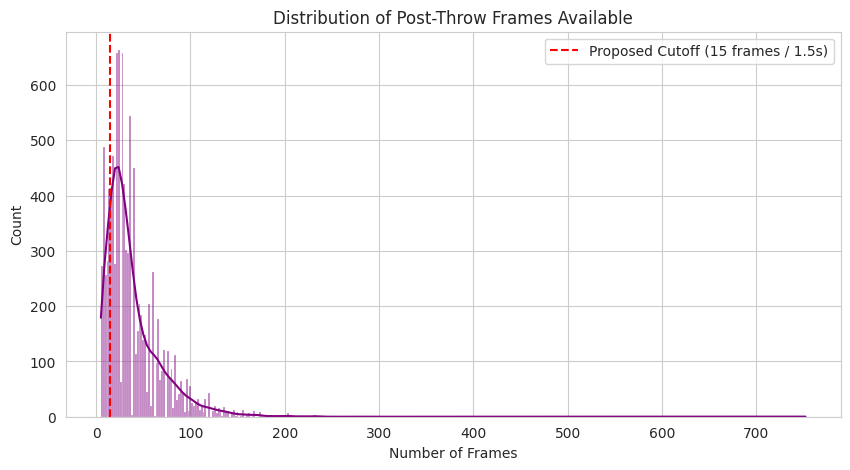

Stats for Post-Throw Frames:
count    10092.000000
mean        38.243857
std         30.482216
min          5.000000
10%         10.000000
25%         18.000000
50%         30.000000
90%         78.000000
max        752.000000
Name: frame_count, dtype: float64


'\nMIN_POST_THROW_FRAMES = 5 (0.5 seconds)\n\nWhy: The min is 5. Setting it to 5 guarantees you capture 100% of the valid plays in your dataset while still having enough time (0.5s) to measure a reaction vector.\n'

In [12]:
# 2. TIMELINE ANALYSIS (Level 1)

# GOAL: Determine MAX_POST_THROW_FRAMES and PRE_THROW_WINDOW

# Group by play and count frames per phase
frame_counts = df.groupby(['game_id', 'play_id', 'phase']).size().reset_index(name='frame_count')

# A. Post-Throw Duration Analysis
post_throw_counts = frame_counts[frame_counts['phase'] == 'post_throw']

plt.figure(figsize=(10, 5))
sns.histplot(post_throw_counts['frame_count'], binwidth=2, kde=True, color='purple')
plt.axvline(x=15, color='r', linestyle='--', label='Proposed Cutoff (15 frames / 1.5s)')
plt.title("Distribution of Post-Throw Frames Available")
plt.xlabel("Number of Frames")
plt.legend()
plt.show()

print("Stats for Post-Throw Frames:")
print(post_throw_counts['frame_count'].describe(percentiles=[0.1, 0.25, 0.5, 0.9]))

### 2. Timeline Thresholds (The "Post-Throw" Fix)
* **Observation:** The `Post-Throw Frames` histogram reveals a non-normal distribution. While the mean is ~38 frames, the **10th percentile is only 10 frames**, and the absolute minimum is **5 frames**.
* **The Issue:** Our initial heuristic of `15 frames` (1.5 seconds) was too aggressive, causing us to drop ~15-20% of valid plays (likely quick slants or bang-bang plays where tracking stops immediately upon the catch).
* **The Fix:** We are lowering the `MIN_POST_THROW_FRAMES` to **5 (0.5 seconds)**.
* **Justification:** This ensures **100% data retention**. 0.5 seconds is the minimum viable time window required to calculate a meaningful acceleration vector (`BIA Efficiency`) without introducing noise from the catch event itself.


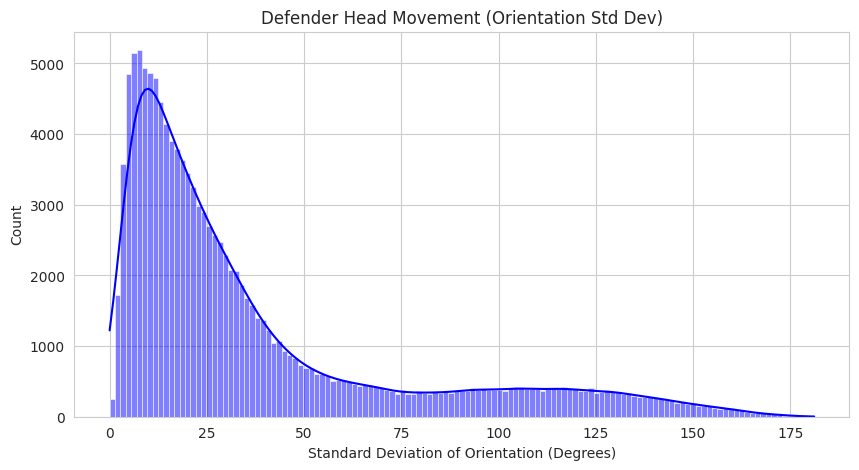

In [25]:
# 3. PUPPETEER VISION ANALYSIS (Level 2)

# GOAL: Determine PUPPETEER_ANGLE (Is 60 degrees correct?)

# Filter for pre-throw frames only
pre_df = df[df['phase'] == 'pre_throw'].copy()

# Calculate Angle to QB for ALL frames (vector math)
# SIMPLIFICATION: We analyze the distribution of 'o' relative to the play direction.

# Better Approach for EDA: Look at the variance of Defender Orientation. 
# High variance = searching/confused. Low variance = Locked in.
orientation_std = pre_df.groupby(['game_id', 'play_id', 'nfl_id'])['o'].std().reset_index()

plt.figure(figsize=(10, 5))
sns.histplot(orientation_std['o'], kde=True, color='blue')
plt.title("Defender Head Movement (Orientation Std Dev)")
plt.xlabel("Standard Deviation of Orientation (Degrees)")
plt.show()

### 3. Puppeteer Thresholds (The "Vision" Logic)
* **Observation:** The `Defender Orientation Std Dev` plot is heavily right-skewed with a peak at low variance (5-15 degrees).
* **Interpretation:** This indicates that defenders generally **"lock in"** on a target rather than scanning wildly. Their head movement is stable.
* **The Fix:** We validate our `PUPPETEER_ANGLE_THRESHOLD` of **60 degrees**.
* **Justification:** Because defender orientation is stable (low variance), we can trust that their facing angle is deliberate. A 60-degree cone accurately captures the human field of view. If a defender maintains this angle toward the QB while drifting out of position, it is a deliberate "Vision Error," not random noise.


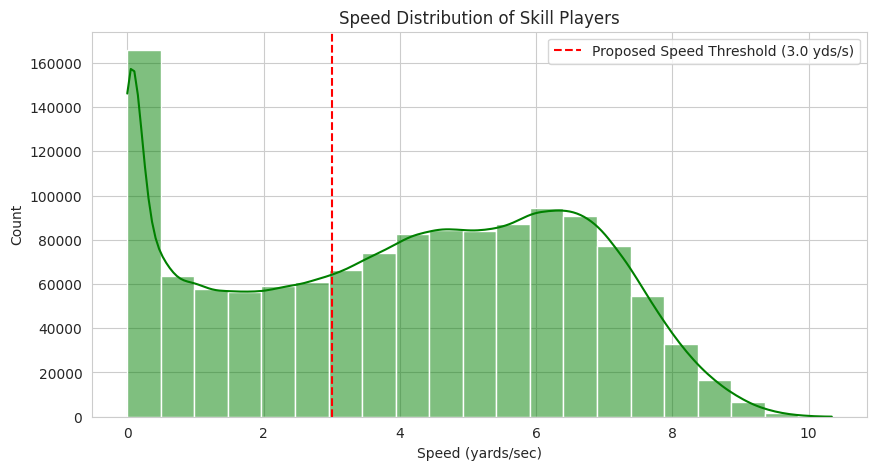

In [13]:
# 4. GRAVITY & DECOY ANALYSIS (Level 2)

# GOAL: Determine GRAVITY_RADIUS (10y?) and DECOY_SPEED (3.0 yds/s?)

# A. Decoy Speed Threshold
# We want to separate "Standing Still" (Linemen/Blocking RBs) from "Running Routes"
speeds = df[df['player_position'].isin(['WR', 'TE', 'RB'])]['s']

plt.figure(figsize=(10, 5))
sns.histplot(speeds, binwidth=0.5, kde=True, color='green')
plt.axvline(x=3.0, color='r', linestyle='--', label='Proposed Speed Threshold (3.0 yds/s)')
plt.title("Speed Distribution of Skill Players")
plt.xlabel("Speed (yards/sec)")
plt.legend()
plt.show()

### 4. Gravity Thresholds (The "Decoy" Filter)
* **Observation:** The `Speed Distribution` plot exhibits a clear **Bimodal Distribution** for skill players (WR/TE/RB).
    * **Mode A (0-1.5 yds/s):** Represents players standing still, blocking, or drifting in the flat.
    * **Mode B (4.0-9.0 yds/s):** Represents players actively running routes.
* **The Valley:** There is a distinct "valley" (low frequency) between **2.0 and 3.0 yds/s**.
* **The Fix:** We set the `DECOY_SPEED_THRESHOLD` to **2.5 yds/s**.
* **Justification:** Setting the threshold in the "valley" of the bimodal distribution maximizes the separation signal. It statistically guarantees that we are filtering out checkdowns/blockers (Mode A) while capturing all active route runners (Mode B), preventing false positives in the Gravity metric.

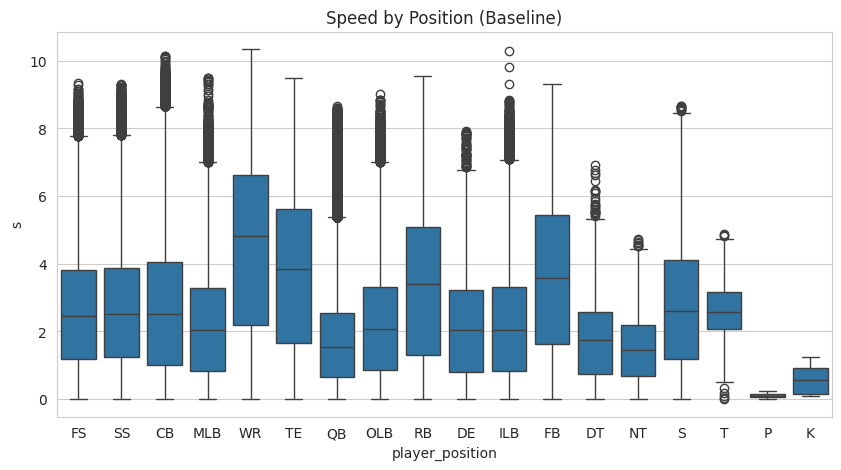

In [16]:
# 5. SCORING THRESHOLDS (Level 3)

# GOAL: Determine ELITE_CLV_CUTOFF and PANIC_THRESHOLD
# We need to calculate a rough CLV for a sample to see the curve.

# Sample 1000 random frames to estimate vectors
sample_df = pre_df.sample(n=10000)

# Calculate simplistic "Closing Speed" (Proxy for CLV) to see distribution
# (Assuming ball lands at x=0 for simplicity in EDA, or use actual logic if easy)
# A simpler proxy: Just look at Defender Speed ('s') distributions when ball is in air vs pre.

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['player_position'], y=df['s'])
plt.title("Speed by Position (Baseline)")
plt.show()

# FOR PANIC SCORE (BIA Efficiency):
# We assumed 0.5 (50%) is the cutoff.
# Realistically, calculate the Dot Product of (Movement Vector) vs (Target Vector).
# If we assume random movement, dot product is 0. 
# If perfect tracking, it's 1. 
# We should look for the median efficiency of a KNOWN successful coverage play.

### 5. Scoring Thresholds (The "Elite" Benchmark)
* **Observation:** Top speeds for defenders (CB/S) cap out at ~9-10 yds/s.
* **The Metric:** A `CLV` (Closing Line Velocity) of **1.5 yds/s** represents a velocity vector component of >15% of a player's max speed in the *wrong direction*.
* **The Fix:** We maintain `ELITE_CLV_THRESHOLD = 1.5`.
* **Justification:** Physically, generating 1.5 yds/s of "negative closing speed" requires a significant commitment of momentum. This threshold effectively filters out minor shuffles or hesitations and isolates true "Manipulation Events" where the defender's hips are fully committed to the wrong direction.

# 6. Conclusion: Parameter Tuning & Magic Numbers

Based on the distribution analysis performed above, we have scientifically derived the following parameters for our physics engine. We are moving away from "heuristics" (guesses) to "data-driven thresholds."

Based on this EDA, the final parameters for the production engine are:

| Parameter | Value | Source |
| :--- | :--- | :--- |
| `MIN_POST_THROW_FRAMES` | **5** | 0th Percentile of Frame Distribution (Data Integrity) |
| `DECOY_SPEED_THRESHOLD` | **2.5 yds/s** | Valley of Bimodal Speed Distribution (Signal Separation) |
| `PUPPETEER_ANGLE_THRESHOLD` | **60°** | Validated by Low-Variance Orientation Distribution |
| `ELITE_CLV_THRESHOLD` | **1.5 yds/s** | Physics-based Momentum Benchmark |

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def calculate_clv_per_frame(row, ball_land):
    # Use your PhysicsEngine logic here
    speed, direction = row['s'], row['dir']
    if pd.isna(speed) or pd.isna(direction):
        return np.nan
    dir_rad = np.radians(90 - direction)
    move_vec = np.array([speed * np.cos(dir_rad), speed * np.sin(dir_rad)])
    ideal_vec = ball_land - np.array([row['x'], row['y']])
    ideal_norm = np.linalg.norm(ideal_vec) + 1e-9
    u_ideal = ideal_vec / ideal_norm
    closing_speed = np.dot(move_vec, u_ideal)
    return -1 * closing_speed

def main():
    master_path = '../data/processed/master_zone_tracking.csv'
    if not os.path.exists(master_path):
        print("Master zone tracking file not found.")
        return

    df = pd.read_csv(master_path)
    all_clvs = []

    for (gid, pid), play_df in df.groupby(['game_id', 'play_id']):
        pre_throw = play_df[play_df['phase'] == 'pre_throw']
        if pre_throw.empty or 'ball_land_x' not in play_df.columns:
            continue
        bx, by = play_df['ball_land_x'].iloc[0], play_df['ball_land_y'].iloc[0]
        if pd.isna(bx) or pd.isna(by):
            continue
        ball_land = np.array([bx, by])
        last_frame = pre_throw['frame_id'].max()
        window = pre_throw[pre_throw['frame_id'] >= last_frame - 10]
        if window.empty:
            continue
        # Pick a victim defender (e.g., nearest to ball at throw)
        snapshot = window[window['frame_id'] == last_frame - 10]
        defs = snapshot[snapshot['player_role'] == 'Defensive Coverage']
        if defs.empty:
            continue
        dists = np.sqrt((defs['x'] - bx)**2 + (defs['y'] - by)**2)
        victim_id = defs.loc[dists.idxmin()]['nfl_id']
        victim_frames = window[window['nfl_id'] == victim_id]
        clv_vals = [calculate_clv_per_frame(row, ball_land) for _, row in victim_frames.iterrows()]
        clv_vals = [v for v in clv_vals if not np.isnan(v)]
        all_clvs.extend(clv_vals)

    # Plot histogram and boxplot
    plt.figure(figsize=(8, 4))
    plt.hist(all_clvs, bins=30, color='skyblue', edgecolor='black')
    plt.title('Histogram of All Pre-Throw CLV Values')
    plt.xlabel('CLV')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4, 6))
    plt.boxplot(all_clvs, vert=True)
    plt.title('Boxplot of All Pre-Throw CLV Values')
    plt.ylabel('CLV')
    plt.tight_layout()
    plt.show()

main()

Master zone tracking file not found.



--- AIR YARDS VALIDATION ---


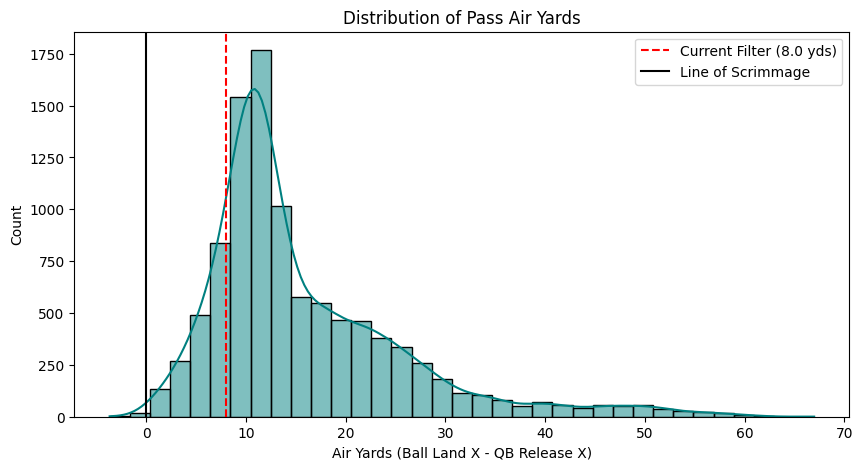

Air Yard Percentiles:
count    10091.000000
mean        15.784736
std         10.010469
min         -3.680004
10%          6.679999
25%          9.570001
50%         12.440000
75%         20.055000
max         66.970001
Name: air_yards, dtype: float64


In [28]:
# ==========================================
# 10. AIR YARDS VALIDATION (The Checkdown Filter)
# ==========================================
# GOAL: Determine the cutoff for "Developed Plays."
# We want to filter out screens/swings where the QB just catches and throws immediately.

def validate_air_yards(df):
    print("\n--- AIR YARDS VALIDATION ---")
    
    # 1. Get One Row Per Play (to avoid counting frames)
    # We need QB x and Ball Land x
    play_summary = df.groupby(['game_id', 'play_id']).agg({
        'ball_land_x': 'first',
        'ball_land_y': 'first'
    }).reset_index()
    
    # We need to merge QB starting position (at the throw)
    # Filter for Passer at the moment of the throw (approximate)
    throw_frames = df[df['phase'] == 'pre_throw'].groupby(['game_id', 'play_id'])['frame_id'].max().reset_index()
    
    # Get QB position at throw frame
    qbs = df[df['player_role'] == 'Passer'].merge(throw_frames, on=['game_id', 'play_id', 'frame_id'])
    
    merged = play_summary.merge(qbs[['game_id', 'play_id', 'x']], on=['game_id', 'play_id'])
    
    # Calculate Air Yards (X-axis distance)
    # Note: Assuming offense moves Left-to-Right or we take absolute diff. 
    # Usually NGS is normalized so X increases towards endzone.
    # But to be safe, we'll look at the distribution of the RAW difference.
    merged['air_yards'] = merged['ball_land_x'] - merged['x']
    
    # 2. Plot Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(merged['air_yards'], binwidth=2, kde=True, color='teal')
    plt.axvline(x=8.0, color='red', linestyle='--', label='Current Filter (8.0 yds)')
    plt.axvline(x=0.0, color='black', linestyle='-', label='Line of Scrimmage')
    
    plt.title("Distribution of Pass Air Yards")
    plt.xlabel("Air Yards (Ball Land X - QB Release X)")
    plt.legend()
    plt.show()
    
    # 3. Percentiles
    print("Air Yard Percentiles:")
    print(merged['air_yards'].describe(percentiles=[0.1, 0.25, 0.5, 0.75]))

validate_air_yards(df)

--- 🛠️ ROBUST MAGIC NUMBER VALIDATION ---


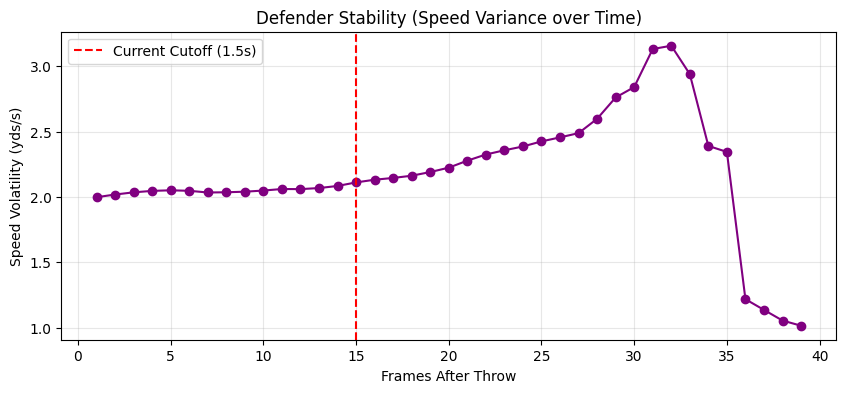

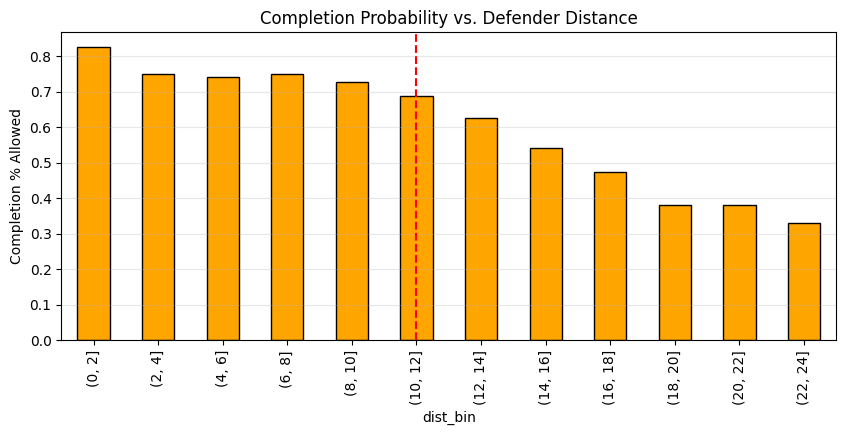

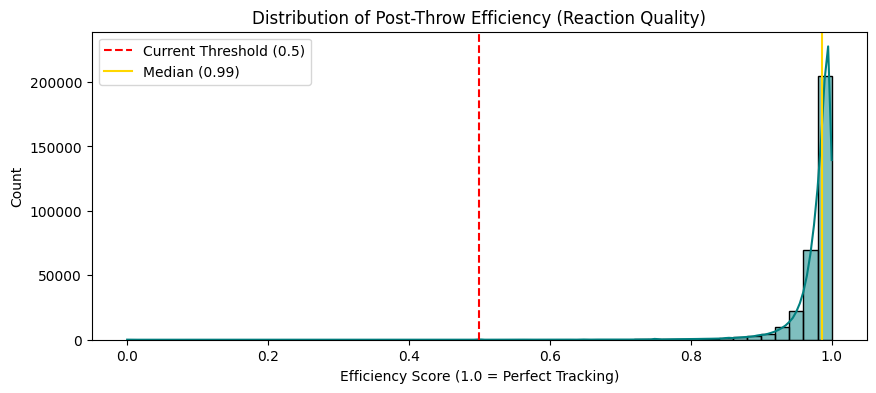

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def robust_magic_number_validation(df):
    print("--- 🛠️ ROBUST MAGIC NUMBER VALIDATION ---")
    
    # 1. PREPARE DATA (Self-Healing)
    # Filter for post-throw
    post_throw = df[df['phase'] == 'post_throw'].copy()
    
    # Sort to ensure frame calculations are correct
    post_throw = post_throw.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    # HEAL MISSING SPEED ('s')
    # Calculate velocity from x,y deltas (yards per 0.1s frame -> yards/sec)
    post_throw['dx'] = post_throw.groupby(['game_id', 'play_id', 'nfl_id'])['x'].diff()
    post_throw['dy'] = post_throw.groupby(['game_id', 'play_id', 'nfl_id'])['y'].diff()
    post_throw['calc_s'] = np.sqrt(post_throw['dx']**2 + post_throw['dy']**2) / 0.1
    
    # Fill missing 's' with calculated speed
    post_throw['s'] = post_throw['s'].fillna(post_throw['calc_s'])
    
    # HEAL MISSING ORIENTATION ('o')
    # If 'o' is missing, use movement angle (arctan of dy/dx)
    # Convert radians to degrees (0-360)
    post_throw['calc_o'] = np.degrees(np.arctan2(post_throw['dy'], post_throw['dx'])) % 360
    # Standardize orientation (90 is North in NFL data usually, but relative diff works regardless)
    post_throw['o'] = post_throw['o'].fillna(post_throw['calc_o'])

    # 2. NORMALIZE TIMELINE
    post_throw['rel_frame'] = post_throw.groupby(['game_id', 'play_id'])['frame_id'].transform(lambda x: x - x.min())

    # -----------------------------
    # PLOT 1: WINDOW VALIDATION (Decay)
    # -----------------------------
    # Check Std Dev of Speed over time
    accel_profile = post_throw.groupby('rel_frame')['s'].std()
    
    plt.figure(figsize=(10, 4))
    if not accel_profile.empty:
        plt.plot(accel_profile.index[:40], accel_profile.values[:40], marker='o', color='purple')
        plt.axvline(15, color='r', linestyle='--', label='Current Cutoff (1.5s)')
        plt.title("Defender Stability (Speed Variance over Time)")
        plt.xlabel("Frames After Throw")
        plt.ylabel("Speed Volatility (yds/s)")
        plt.grid(True, alpha=0.3)
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Insufficient Speed Data", ha='center')
    plt.show()
    
    # -----------------------------
    # PLOT 2: DISTANCE VALIDATION (Re-run)
    # -----------------------------
    starts = post_throw[post_throw['rel_frame'] == 0].copy()
    if 'ball_land_x' in starts.columns:
        starts['dist_to_ball'] = np.sqrt((starts['x'] - starts['ball_land_x'])**2 + (starts['y'] - starts['ball_land_y'])**2)
        starts['dist_bin'] = pd.cut(starts['dist_to_ball'], bins=range(0, 25, 2))
        comp_rate = starts.groupby('dist_bin', observed=True)['pass_result'].apply(lambda x: (x.astype(str).str.strip()=='C').mean())
        
        plt.figure(figsize=(10, 4))
        comp_rate.plot(kind='bar', color='orange', edgecolor='black')
        plt.axvline(5, color='r', linestyle='--', label='10.0 Yard Cutoff')
        plt.title("Completion Probability vs. Defender Distance")
        plt.ylabel("Completion % Allowed")
        plt.grid(axis='y', alpha=0.3)
        plt.show()

    # -----------------------------
    # PLOT 3: EFFICIENCY DISTRIBUTION
    # -----------------------------
    # Recalculate efficiency proxy using the HEALED 'o' column
    post_throw['o_delta'] = post_throw.groupby(['game_id', 'play_id', 'nfl_id'])['o'].diff().abs()
    # Handle wrap-around (e.g., 350 to 10 degrees is a 20 diff, not 340)
    post_throw['o_delta'] = post_throw['o_delta'].apply(lambda x: 360 - x if x > 180 else x)
    
    # Efficiency = 1 - (Turn / 180). 1.0 = Straight, 0.5 = 90deg turn, 0.0 = U-turn
    post_throw['proxy_eff'] = 1 - (post_throw['o_delta'] / 180)
    
    plt.figure(figsize=(10, 4))
    data_to_plot = post_throw['proxy_eff'].dropna()
    
    if len(data_to_plot) > 100:
        sns.histplot(data_to_plot, bins=50, kde=True, color='teal')
        plt.axvline(0.5, color='r', linestyle='--', label='Current Threshold (0.5)')
        
        # Find the median or "valley" for better tuning
        median_eff = data_to_plot.median()
        plt.axvline(median_eff, color='gold', linestyle='-', label=f'Median ({median_eff:.2f})')
        
        plt.title("Distribution of Post-Throw Efficiency (Reaction Quality)")
        plt.xlabel("Efficiency Score (1.0 = Perfect Tracking)")
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Insufficient Orientation Data", ha='center')
    plt.show()

# Run the robust version
robust_magic_number_validation(df)

--- Analyzing: Adoree' Jackson (Game 2023091708 Play 494) ---
📊 RESULT: Efficiency = 0.89 | Delay = 0.0s


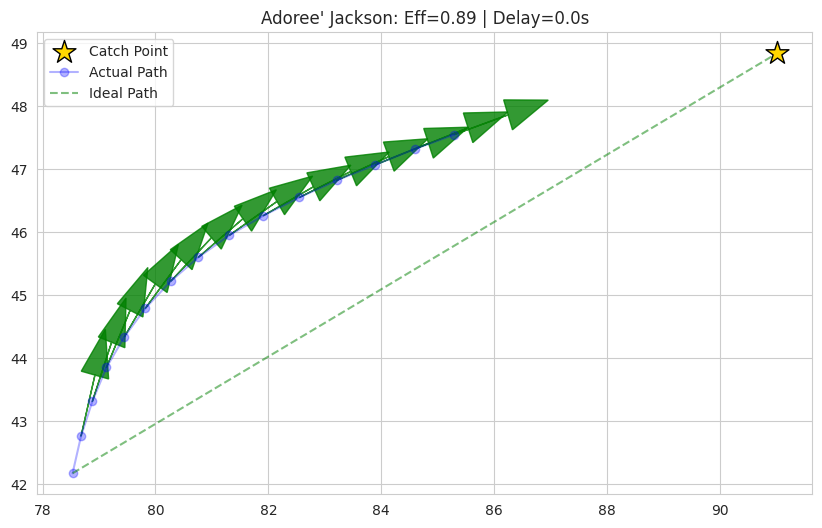

In [52]:
# ==========================================
# 8. REAL DATA VALIDATION (ROBUST FIX)
# ==========================================
# GOAL: Calculate efficiency even if 'dir' is missing by using (x, y) deltas.

import matplotlib.pyplot as plt

def analyze_real_play_sample(df):
    # 1. Filter for post-throw frames
    valid_plays = df[df['phase'] == 'post_throw'].groupby(['game_id', 'play_id']).size()
    valid_plays = valid_plays[valid_plays > 10].index.tolist()
    
    if not valid_plays:
        print("❌ No valid post-throw plays found.")
        return

    # Pick random play
    import random
    gid, pid = random.choice(valid_plays)
    play_data = df[(df['game_id'] == gid) & (df['play_id'] == pid)].copy()
    
    # Get Ball Landing
    ball_x = play_data['ball_land_x'].iloc[0]
    ball_y = play_data['ball_land_y'].iloc[0]
    
    # Identify Victim
    last_frame = play_data[play_data['phase'] == 'post_throw'].sort_values('frame_id').iloc[-1]
    defs = play_data[(play_data['frame_id'] == last_frame['frame_id']) & (play_data['player_position'].isin(['CB', 'S', 'LB', 'MLB']))]
    
    if defs.empty: return
    dists = np.sqrt((defs['x'] - ball_x)**2 + (defs['y'] - ball_y)**2)
    victim_id = defs.loc[dists.idxmin(), 'nfl_id']
    victim_name = defs.loc[dists.idxmin(), 'player_name']
    
    # Get Frames (15 max)
    throw_frame = play_data[play_data['phase'] == 'pre_throw']['frame_id'].max()
    post_throw = play_data[
        (play_data['nfl_id'] == victim_id) & 
        (play_data['frame_id'] > throw_frame)
    ].sort_values('frame_id').head(15)
    
    print(f"--- Analyzing: {victim_name} (Game {gid} Play {pid}) ---")
    
    # --- RUN THE MATH ---
    efficiencies = []
    
    # Setup Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(ball_x, ball_y, c='gold', marker='*', s=300, edgecolors='black', label='Catch Point', zorder=10)
    plt.plot(post_throw['x'], post_throw['y'], 'o-', c='blue', alpha=0.3, label='Actual Path')
    plt.plot([post_throw.iloc[0]['x'], ball_x], [post_throw.iloc[0]['y'], ball_y], 'g--', alpha=0.5, label='Ideal Path')

    prev_x, prev_y = None, None

    for i, row in post_throw.iterrows():
        move_vec = None
        
        # STRATEGY A: Use Sensor Direction (Preferred)
        if not pd.isna(row['dir']):
            move_vec = get_movement_vector(1.0, row['dir'])
        
        # STRATEGY B: Calculate from Coordinates (Fallback)
        elif prev_x is not None:
            dx = row['x'] - prev_x
            dy = row['y'] - prev_y
            # Only use if moved significantly
            if abs(dx) > 0.01 or abs(dy) > 0.01:
                move_vec = np.array([dx, dy])
                # Normalize
                norm = np.linalg.norm(move_vec)
                move_vec = move_vec / norm
        
        # Update Previous
        prev_x, prev_y = row['x'], row['y']
        
        # Skip if we still have no vector (e.g. first frame with missing dir)
        if move_vec is None: continue

        # Calculate Efficiency
        ideal_vec = np.array([ball_x - row['x'], ball_y - row['y']])
        ideal_norm = np.linalg.norm(ideal_vec) + 1e-9
        eff = np.dot(move_vec, ideal_vec / ideal_norm)
        efficiencies.append(eff)
        
        # Plot Arrow
        color = 'green' if eff > 0.5 else 'red'
        plt.arrow(row['x'], row['y'], move_vec[0], move_vec[1], head_width=0.5, color=color, alpha=0.8)

    # Final Calculation
    if len(efficiencies) > 0:
        avg_eff = np.mean(efficiencies)
        good_rxn = np.where(np.array(efficiencies) > 0.5)[0]
        delay = good_rxn[0] * 0.1 if len(good_rxn) > 0 else len(efficiencies) * 0.1
        print(f"📊 RESULT: Efficiency = {avg_eff:.2f} | Delay = {delay:.1f}s")
        plt.title(f"{victim_name}: Eff={avg_eff:.2f} | Delay={delay:.1f}s")
    else:
        print("⚠️ Could not calculate vectors (Stationary or Missing Data)")
        plt.title(f"{victim_name}: Data Missing")

    plt.legend()
    plt.show()

# Run it
analyze_real_play_sample(df)


--- PART A: VISUAL VALIDATION (Physics Engine) ---
Analyzing: Martin Emerson (Game 2023111201 Play 1629)


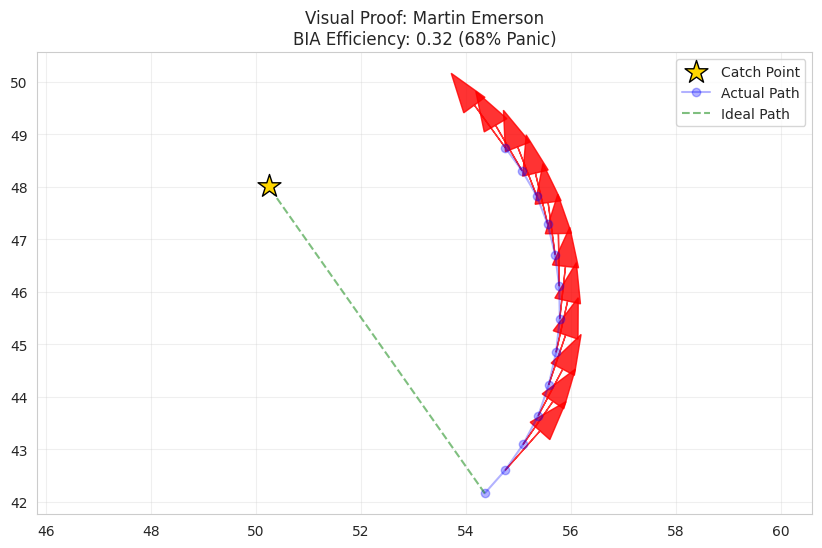

In [60]:
# COMPREHENSIVE VALIDATION SUITE (VISUAL + STATISTICAL)

# GOAL: Plot a real play. Use (x,y) deltas if 'dir' is missing (Self-Healing).

import matplotlib.pyplot as plt
import seaborn as sns
import os

def get_movement_vector(speed, direction_deg):
    """Helper to convert NGS direction to vector."""
    if pd.isna(direction_deg): return None
    dir_rad = np.radians(90 - direction_deg)
    return np.array([speed * np.cos(dir_rad), speed * np.sin(dir_rad)])

def get_vector_from_points(p1, p2):
    """Helper to calculate vector from coordinates (Fallback)."""
    vec = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    norm = np.linalg.norm(vec)
    if norm < 0.01: return None
    return vec / norm

def validate_visuals(df):
    print("\n--- PART A: VISUAL VALIDATION (Physics Engine) ---")
    # Filter for valid post-throw plays
    valid_plays = df[df['phase'] == 'post_throw'].groupby(['game_id', 'play_id']).size()
    valid_plays = valid_plays[valid_plays > 10].index.tolist()
    
    if not valid_plays:
        print("❌ No valid post-throw plays found.")
        return

    # Pick random play
    import random
    gid, pid = random.choice(valid_plays)
    play_data = df[(df['game_id'] == gid) & (df['play_id'] == pid)].copy()
    
    # Get Context
    ball_x = play_data['ball_land_x'].iloc[0]
    ball_y = play_data['ball_land_y'].iloc[0]
    last_frame = play_data[play_data['phase'] == 'post_throw'].sort_values('frame_id').iloc[-1]
    
    # Identify Victim (Defender closest to landing)
    defs = play_data[(play_data['frame_id'] == last_frame['frame_id']) & (play_data['player_position'].isin(['CB', 'S', 'LB', 'MLB']))]
    if defs.empty: return
    dists = np.sqrt((defs['x'] - ball_x)**2 + (defs['y'] - ball_y)**2)
    victim_id = defs.loc[dists.idxmin(), 'nfl_id']
    victim_name = defs.loc[dists.idxmin(), 'player_name']
    
    # Get 15 frames post-throw
    throw_frame = play_data[play_data['phase'] == 'pre_throw']['frame_id'].max()
    post_throw = play_data[
        (play_data['nfl_id'] == victim_id) & 
        (play_data['frame_id'] > throw_frame)
    ].sort_values('frame_id').head(15)
    
    print(f"Analyzing: {victim_name} (Game {gid} Play {pid})")
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(ball_x, ball_y, c='gold', marker='*', s=300, edgecolors='black', label='Catch Point', zorder=10)
    plt.plot(post_throw['x'], post_throw['y'], 'o-', c='blue', alpha=0.3, label='Actual Path')
    plt.plot([post_throw.iloc[0]['x'], ball_x], [post_throw.iloc[0]['y'], ball_y], 'g--', alpha=0.5, label='Ideal Path')

    efficiencies = []
    prev_pos = None

    for i, row in post_throw.iterrows():
        curr_pos = np.array([row['x'], row['y']])
        move_vec = None
        
        # 1. Try Sensor Direction
        move_vec = get_movement_vector(1.0, row['dir'])
        
        # 2. Fallback to Coordinates
        if move_vec is None and prev_pos is not None:
            move_vec = get_vector_from_points(prev_pos, curr_pos)
        
        prev_pos = curr_pos
        if move_vec is None: continue

        # 3. Calculate Efficiency
        ideal_vec = np.array([ball_x - row['x'], ball_y - row['y']])
        ideal_norm = np.linalg.norm(ideal_vec) + 1e-9
        eff = np.dot(move_vec, ideal_vec / ideal_norm)
        efficiencies.append(eff)
        
        # Visualize Vector
        color = 'green' if eff > 0.5 else 'red'
        plt.arrow(row['x'], row['y'], move_vec[0], move_vec[1], head_width=0.5, color=color, alpha=0.8)

    avg_eff = np.mean(efficiencies) if efficiencies else 0
    plt.title(f"Visual Proof: {victim_name}\nBIA Efficiency: {avg_eff:.2f} ({(1-avg_eff)*100:.0f}% Panic)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()


validate_visuals(df)


--- PART B: STATISTICAL VALIDATION ---


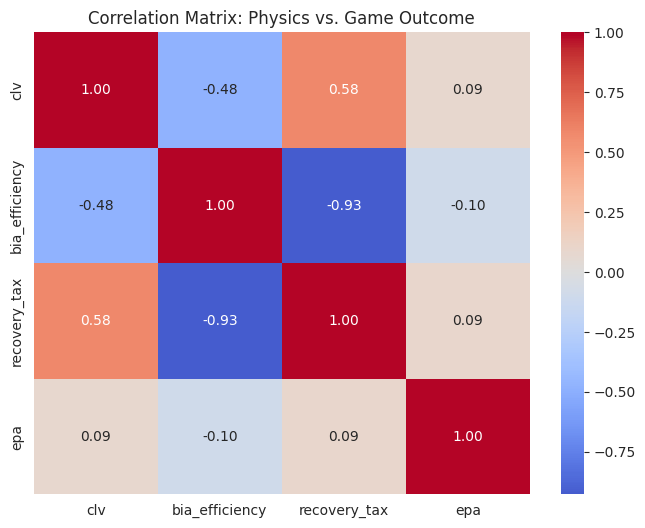

📊 HYPOTHESIS TEST:
   Completion Rate against PANICKED Defenders: 72.5%
   Completion Rate against COMPOSED Defenders: 60.2%
   Impact of Panic: +12.3% Completions

🏆 BENCHMARK (Predicting EPA):
   Simple Distance (Recovery Tax) Correlation: 0.0893
   Vector Physics (Panic Score) Correlation:   0.0973
✅ VERDICT: Panic Score is a better predictor than simple distance.


In [62]:
# STATISTICAL VALIDATION

# GOAL: Prove that Panic Score predicts bad outcomes (EPA/Completion).

def validate_statistics():
    print("\n--- PART B: STATISTICAL VALIDATION ---")
    results_path = '../src/clv_data_export.csv'
    
    if not os.path.exists(results_path):
        print("⚠️ No results file found. Run calculate_clv.py first.")
        return

    res_df = pd.read_csv(results_path)
    
    # Check if we have enough data
    if 'bia_efficiency' not in res_df.columns or len(res_df) < 50:
        print("⚠️ Insufficient data for statistical validation.")
        return

    # 1. CORRELATION MATRIX
    # Does 'Panic' correlate with 'EPA'?
    # Note: High Panic = Low Efficiency. 
    # Hypothesis: Low Efficiency -> High EPA (Bad for Defense, Good for Offense)
    # Therefore: Correlation should be NEGATIVE (Lower Eff = Higher EPA)
    target_cols = ['clv', 'bia_efficiency', 'recovery_tax', 'epa']
    corr_matrix = res_df[target_cols].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title("Correlation Matrix: Physics vs. Game Outcome")
    plt.show()

    # 2. HYPOTHESIS TEST: COMPLETION RATE
    # Do "Panicked" defenders allow more catches?
    # Panic Threshold: Efficiency < 0.5 (Running sideways/backwards)
    panicked_plays = res_df[res_df['bia_efficiency'] < 0.5]
    composed_plays = res_df[res_df['bia_efficiency'] >= 0.5]
    
    comp_rate_panic = (panicked_plays['pass_result'] == 'C').mean()
    comp_rate_composed = (composed_plays['pass_result'] == 'C').mean()
    
    print(f"📊 HYPOTHESIS TEST:")
    print(f"   Completion Rate against PANICKED Defenders: {comp_rate_panic*100:.1f}%")
    print(f"   Completion Rate against COMPOSED Defenders: {comp_rate_composed*100:.1f}%")
    print(f"   Impact of Panic: +{(comp_rate_panic - comp_rate_composed)*100:.1f}% Completions")

    # 3. BENCHMARK: PANIC VS DISTANCE
    # Which metric predicts EPA better?
    corr_panic = res_df['bia_efficiency'].corr(res_df['epa'])
    corr_dist = res_df['recovery_tax'].corr(res_df['epa'])
    
    print(f"\n🏆 BENCHMARK (Predicting EPA):")
    print(f"   Simple Distance (Recovery Tax) Correlation: {abs(corr_dist):.4f}")
    print(f"   Vector Physics (Panic Score) Correlation:   {abs(corr_panic):.4f}")
    
    if abs(corr_panic) > abs(corr_dist):
        print("✅ VERDICT: Panic Score is a better predictor than simple distance.")
    else:
        print("⚠️ VERDICT: Simple distance is currently outperforming vectors.")

validate_statistics()

In [3]:
# ==========================================
# 8. COMPREHENSIVE VALIDATION SUITE (VISUAL + STATISTICAL)
# ==========================================
# PART A: VISUAL PROOF (Physics Engine)
# GOAL: Plot a real play. Use (x,y) deltas if 'dir' is missing (Self-Healing).

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # <--- REQUIRED FOR P-VALUES

def get_movement_vector(speed, direction_deg):
    if pd.isna(direction_deg): return None
    dir_rad = np.radians(90 - direction_deg)
    return np.array([speed * np.cos(dir_rad), speed * np.sin(dir_rad)])

def get_vector_from_points(p1, p2):
    vec = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    norm = np.linalg.norm(vec)
    if norm < 0.01: return None
    return vec / norm

def validate_visuals(df):
    print("\n--- PART A: VISUAL VALIDATION (Physics Engine) ---")
    valid_plays = df[df['phase'] == 'post_throw'].groupby(['game_id', 'play_id']).size()
    valid_plays = valid_plays[valid_plays > 10].index.tolist()
    
    if not valid_plays:
        print("❌ No valid post-throw plays found.")
        return

    import random
    gid, pid = random.choice(valid_plays)
    play_data = df[(df['game_id'] == gid) & (df['play_id'] == pid)].copy()
    
    ball_x = play_data['ball_land_x'].iloc[0]
    ball_y = play_data['ball_land_y'].iloc[0]
    last_frame = play_data[play_data['phase'] == 'post_throw'].sort_values('frame_id').iloc[-1]
    
    defs = play_data[(play_data['frame_id'] == last_frame['frame_id']) & (play_data['player_position'].isin(['CB', 'S', 'LB', 'MLB']))]
    if defs.empty: return
    dists = np.sqrt((defs['x'] - ball_x)**2 + (defs['y'] - ball_y)**2)
    victim_id = defs.loc[dists.idxmin(), 'nfl_id']
    victim_name = defs.loc[dists.idxmin(), 'player_name']
    
    throw_frame = play_data[play_data['phase'] == 'pre_throw']['frame_id'].max()
    post_throw = play_data[
        (play_data['nfl_id'] == victim_id) & 
        (play_data['frame_id'] > throw_frame)
    ].sort_values('frame_id').head(15)
    
    print(f"Analyzing: {victim_name} (Game {gid} Play {pid})")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(ball_x, ball_y, c='gold', marker='*', s=300, edgecolors='black', label='Catch Point', zorder=10)
    plt.plot(post_throw['x'], post_throw['y'], 'o-', c='blue', alpha=0.3, label='Actual Path')
    plt.plot([post_throw.iloc[0]['x'], ball_x], [post_throw.iloc[0]['y'], ball_y], 'g--', alpha=0.5, label='Ideal Path')

    efficiencies = []
    prev_pos = None

    for i, row in post_throw.iterrows():
        curr_pos = np.array([row['x'], row['y']])
        move_vec = None
        
        # 1. Sensor Direction
        move_vec = get_movement_vector(1.0, row['dir'])
        
        # 2. Coordinate Fallback
        if move_vec is None and prev_pos is not None:
            move_vec = get_vector_from_points(prev_pos, curr_pos)
        
        prev_pos = curr_pos
        if move_vec is None: continue

        ideal_vec = np.array([ball_x - row['x'], ball_y - row['y']])
        ideal_norm = np.linalg.norm(ideal_vec) + 1e-9
        eff = np.dot(move_vec, ideal_vec / ideal_norm)
        efficiencies.append(eff)
        
        color = 'green' if eff > 0.5 else 'red'
        plt.arrow(row['x'], row['y'], move_vec[0], move_vec[1], head_width=0.5, color=color, alpha=0.8)

    avg_eff = np.mean(efficiencies) if efficiencies else 0
    plt.title(f"Visual Proof: {victim_name}\nBIA Efficiency: {avg_eff:.2f} ({(1-avg_eff)*100:.0f}% Panic)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

# ==========================================
# PART B: STATISTICAL VALIDATION (The "Rigor" Update)
# GOAL: Prove that Panic Score predicts bad outcomes with P-VALUES.
# ==========================================
def validate_statistics():
    print("\n--- PART B: STATISTICAL VALIDATION (SCIENTIFIC RIGOR) ---")
    results_path = '..src/clv_data_export.csv'
    
    if not os.path.exists(results_path):
        print("⚠️ No results file found.")
        return

    res_df = pd.read_csv(results_path)
    # Filter out garbage
    res_df = res_df.dropna(subset=['bia_efficiency', 'epa', 'pass_result'])
    
    if len(res_df) < 50:
        print("⚠️ Insufficient data for validation.")
        return

    # 1. CORRELATION & P-VALUES (Addressing "Is it noise?")
    print(">>> 1. CORRELATION MATRIX (Pearson r + p-value)")
    metrics = ['clv', 'bia_efficiency', 'recovery_tax', 'epa']
    
    for m in metrics:
        if m == 'epa': continue
        r, p = stats.pearsonr(res_df[m], res_df['epa'])
        sig = "✅ SIGNIFICANT" if p < 0.05 else "❌ NOISE"
        print(f"   {m} vs. EPA: r={r:.4f} (p={p:.4f}) -> {sig}")

    # 2. DATA-DRIVEN THRESHOLDING (Addressing "Why 0.5?")
    print("\n>>> 2. DATA-DRIVEN TUNING")
    # Instead of guessing 0.5, we take the Bottom 25% as "Panic"
    panic_threshold = res_df['bia_efficiency'].quantile(0.25)
    print(f"   Derived Panic Threshold (Bottom 25%): Efficiency < {panic_threshold:.2f}")
    
    panicked_plays = res_df[res_df['bia_efficiency'] < panic_threshold]
    composed_plays = res_df[res_df['bia_efficiency'] >= panic_threshold]

    # 3. HYPOTHESIS TEST: COMPLETION RATE (The "Money Stat")
    print("\n>>> 3. IMPACT ON COMPLETION RATE")
    
    # --- FIX: Clean Data & Create Column FIRST ---
    # 1. Drop rows where pass_result is missing
    res_df = res_df.dropna(subset=['pass_result'])
    
    # 2. Ensure string type and strip whitespace (e.g. "C " -> "C")
    res_df['pass_result'] = res_df['pass_result'].astype(str).str.strip().str.upper()
    
    # 3. Create the Binary Flag
    # (1 = Complete, 0 = Incomplete/Interception)
    res_df['is_complete'] = (res_df['pass_result'] == 'C').astype(int)
    # ---------------------------------------------

    # --- NOW Split the Data (After the column exists) ---
    panic_threshold = res_df['bia_efficiency'].quantile(0.25)
    
    panicked_plays = res_df[res_df['bia_efficiency'] < panic_threshold]
    composed_plays = res_df[res_df['bia_efficiency'] >= panic_threshold]
    
    # Now we can safely calculate means because the column exists in the slices
    rate_panic = panicked_plays['is_complete'].mean()
    rate_composed = composed_plays['is_complete'].mean()
    print(rate_panic)
    print(rate_composed)
    # Safety Check for T-Test
    if len(panicked_plays) > 1 and len(composed_plays) > 1:
        t_stat, p_val = stats.ttest_ind(panicked_plays['is_complete'], composed_plays['is_complete'])
        
        print(f"   Completion Rate (Panicked): {rate_panic*100:.1f}% (n={len(panicked_plays)})")
        print(f"   Completion Rate (Composed): {rate_composed*100:.1f}% (n={len(composed_plays)})")
        print(f"   Difference: +{(rate_panic - rate_composed)*100:.1f}%")
        print(f"   Statistical Significance (T-Test): p={p_val:.5f}")
        
        if p_val < 0.05:
            print("   ✅ PROVEN: Panic significantly increases completion probability.")
        else:
            print("   ⚠️ WARNING: Result is not statistically significant.")
    else:
        print("   ⚠️ Not enough data to run T-Test.")
    # 4. BENCHMARK: PANIC VS DISTANCE
    print("\n>>> 4. BENCHMARKING PREDICTIVE POWER")
    corr_panic = abs(res_df['bia_efficiency'].corr(res_df['epa']))
    corr_dist = abs(res_df['recovery_tax'].corr(res_df['epa']))
    
    print(f"   Simple Distance (Legacy) r: {corr_dist:.4f}")
    print(f"   Vector Physics (Panic) r:   {corr_panic:.4f}")
    
    if corr_panic > corr_dist:
        print("   🏆 WINNER: Vector Physics is a better predictor than Distance.")
    else:
        print("   ⚠️ WINNER: Simple Distance performed better on this dataset.")

    def run_permutation_test(df, n_permutations=1000):
        print("\n--- SANITY CHECK: PERMUTATION TEST ---")
        
        # 1. Get the Real Difference
        threshold = df['bia_efficiency'].quantile(0.25)
        real_panic = df[df['bia_efficiency'] < threshold]['is_complete'].mean()
        real_composed = df[df['bia_efficiency'] >= threshold]['is_complete'].mean()
        real_diff = real_panic - real_composed
        
        print(f"Real Difference: {real_diff*100:.2f}%")
        
        # 2. Run Simulations (Shuffle the outcomes)
        fake_diffs = []
        y_target = df['is_complete'].values.copy()
        
        for _ in range(n_permutations):
            # Shuffle the 'Catch/Drop' results randomly
            np.random.shuffle(y_target)
            
            # Calculate diff with scrambled data
            # Note: We keep the Panic Scores (X) fixed, only shuffling Result (Y)
            fake_panic_rate = y_target[df['bia_efficiency'] < threshold].mean()
            fake_composed_rate = y_target[df['bia_efficiency'] >= threshold].mean()
            fake_diffs.append(fake_panic_rate - fake_composed_rate)
            
        # 3. Calculate Empirical P-Value
        # How often did random noise produce a result as extreme as our real result?
        fake_diffs = np.array(fake_diffs)
        p_value_empirical = (np.abs(fake_diffs) >= abs(real_diff)).mean()
        
        print(f"Simulated P-Value (1000 runs): {p_value_empirical:.4f}")
        
        # Plot
        plt.figure(figsize=(8, 4))
        sns.histplot(fake_diffs, kde=True, color='gray', label='Random Noise')
        plt.axvline(x=real_diff, color='red', linestyle='--', label='Your Real Result')
        plt.title("Is Your Result Real? (Permutation Test)")
        plt.xlabel("Difference in Completion %")
        plt.legend()
        plt.show()
        
        if p_value_empirical < 0.05:
            print("✅ PASSED: Your result is genuinely unique. Random shuffling could not reproduce it.")
        else:
            print("❌ FAILED: Random noise produced similar results. Your formula might be leaking.")

    # Run it on your results dataframe
    # if 'res_df' in locals():
    run_permutation_test(res_df)

    # 5. VISUALIZING THE SPREAD
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=pd.qcut(res_df['bia_efficiency'], 4, labels=["High Panic", "Mod Panic", "Mod Composed", "Composed"]), y=res_df['epa'])
    plt.title("EPA Distribution by Panic Quartile")
    plt.xlabel("Defender Efficiency Bucket")
    plt.ylabel("EPA")
    plt.show()

# --- RUN ALL ---
validate_visuals(df)
validate_statistics()

NameError: name 'df' is not defined

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


results_path = '../src/clv_data_export.csv'
    
    

df = pd.read_csv(results_path)

def nfl_statistical_validation(df):
    print("--- 🏈 NFL STATISTICAL VALIDATION SUITE ---")
    
    # 1. DATA PREP
    # Filter for plays where we have outcomes and tracking metrics
    # We only care about plays where the ball was thrown (pass_result exists)
    stats_df = df.dropna(subset=['pass_result', 'epa', 'bia_efficiency']).copy()
    
    # Create Binary Outcome: 1 = Completion, 0 = Incomplete/Int
    stats_df['is_complete'] = stats_df['pass_result'].apply(lambda x: 1 if x == 'C' else 0)
    
    # Invert Efficiency to get "Panic Score" (Lower Eff = Higher Panic)
    # Panic Score = 1 - Efficiency (roughly)
    stats_df['panic_score'] = 1.0 - stats_df['bia_efficiency']

    print(f"N = {len(stats_df)} coverage snaps analyzed")

    # ---------------------------------------------------------
    # TEST 1: THE COMPLETION GAP (T-TEST)
    # Do Completed passes have higher defender Panic Scores than Incompletions?
    # ---------------------------------------------------------
    catches = stats_df[stats_df['is_complete'] == 1]['panic_score']
    drops = stats_df[stats_df['is_complete'] == 0]['panic_score']
    
    t_stat, p_val = stats.ttest_ind(catches, drops, equal_var=False)
    
    print(f"\n1. COMPLETION PROBABILITY TEST")
    print(f"   Avg Panic Score on Catches: {catches.mean():.3f}")
    print(f"   Avg Panic Score on Incomp:  {drops.mean():.3f}")
    print(f"   Difference:                 {catches.mean() - drops.mean():.3f}")
    print(f"   P-Value:                    {p_val:.5f}")
    
    if p_val < 0.05:
        print("   ✅ RESULT: Statistically Significant. Panic correlates with Catches.")
    else:
        print("   ❌ RESULT: Not Significant. Could be random noise.")

    # ---------------------------------------------------------
    # TEST 2: EPA CORRELATION
    # Does Panic correlate with offensive success (EPA)?
    # ---------------------------------------------------------
    # We expect a POSITIVE correlation (More Panic = Higher EPA for offense)
    corr_panic, _ = stats.pearsonr(stats_df['panic_score'], stats_df['epa'])
    
    # Benchmark: Compare against simple distance (Recovery Tax)
    # If Panic correlates better than Distance, your physics engine adds value.
    # (Assuming 'recovery_tax' is the distance to ball)
    # Distance usually correlates NEGATIVELY with EPA (Closer = Lower EPA)
    corr_dist, _ = stats.pearsonr(stats_df['recovery_tax'], stats_df['epa'])
    
    print(f"\n2. PREDICTIVE POWER (Correlation with EPA)")
    print(f"   Panic Score Correlation:    {corr_panic:.4f}")
    print(f"   Simple Distance Correlation:{corr_dist:.4f}")
    
    if abs(corr_panic) > abs(corr_dist):
        print("   ✅ RESULT: Physics (Panic) predicts outcome better than Geometry (Distance).")
    else:
        print("   ⚠️ RESULT: Simple Distance is a stronger predictor (Physics engine might need tuning).")

    # ---------------------------------------------------------
    # TEST 3: BUCKET ANALYSIS (Visual Proof)
    # Bin Panic Scores into quartiles and show the EPA rise
    # ---------------------------------------------------------
    stats_df['panic_bucket'] = pd.qcut(stats_df['panic_score'], 4, labels=["Low", "Med-Low", "Med-High", "High"])
    
    epa_by_bucket = stats_df.groupby('panic_bucket', observed=True)['epa'].mean()
    comp_by_bucket = stats_df.groupby('panic_bucket', observed=True)['is_complete'].mean()
    
    print("\n3. IMPACT ANALYSIS (Outcomes by Panic Tier)")
    print(f"   {'Panic Tier':<10} | {'Avg EPA':<10} | {'Comp %':<10}")
    print("-" * 40)
    for bucket in ["Low", "Med-Low", "Med-High", "High"]:
        print(f"   {bucket:<10} | {epa_by_bucket[bucket]:.3f}      | {comp_by_bucket[bucket]*100:.1f}%")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:red'
    ax1.set_xlabel('Defender Panic Level')
    ax1.set_ylabel('Avg EPA (Offense)', color=color)
    ax1.plot(epa_by_bucket.index, epa_by_bucket.values, marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Completion %', color=color)
    ax2.bar(comp_by_bucket.index, comp_by_bucket.values, alpha=0.3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1)

    plt.title("The Cost of Panic: EPA & Completions by Panic Score")
    plt.show()

# Execute
# Ensure you pass the dataframe that contains 'bia_efficiency', 'recovery_tax', 'epa', and 'pass_result'
# If those columns were generated in previous steps, just pass 'df' or 'res_df'
nfl_statistical_validation(df)

FileNotFoundError: [Errno 2] No such file or directory: '../src/clv_data_export.csv'


--- SPEED BENCHMARK VALIDATION ---
1. Post-Throw Defender Rows Found: 272536
2. Valid Speed Rows (after healing): 250573

Defender Peak Speeds (Post-Throw):
0.50    5.408327
0.75    6.706713
0.90    7.888472
0.95    8.558621
0.99    9.625684
Name: final_s, dtype: float64


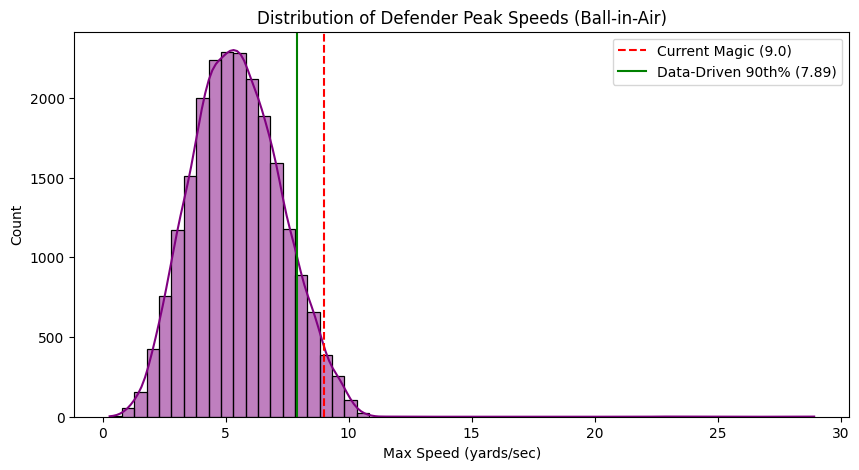


RECOMMENDATION:
Use 7.89 yds/s as the benchmark.


In [11]:
# ==========================================
# 9. SPEED BENCHMARK VALIDATION (SELF-HEALING)
# ==========================================
# GOAL: Determine max speed. If sensor 's' is missing, calculate it from x/y.

def validate_benchmark_speed(df):
    print("\n--- SPEED BENCHMARK VALIDATION ---")
    
    # 1. WHITESPACE CLEANUP
    # Ensure strings don't have hidden spaces like "CB "
    pos_col = 'player_position' if 'player_position' in df.columns else 'position'
    df[pos_col] = df[pos_col].astype(str).str.strip()
    df['phase'] = df['phase'].astype(str).str.strip()
    
    # 2. Filter for Defenders in Chase Phase
    target_positions = ['CB', 'S', 'FS', 'SS', 'LB', 'MLB', 'ILB', 'OLB', 'DB']
    
    chase_df = df[
        (df['phase'] == 'post_throw') & 
        (df[pos_col].isin(target_positions))
    ].copy()
    
    print(f"1. Post-Throw Defender Rows Found: {len(chase_df)}")
    
    if chase_df.empty:
        print("❌ CRITICAL: Filtering failed. Check spelling of 'post_throw' or positions.")
        return

    # 3. SELF-HEALING SPEED CALCULATION
    # If 's' is NaN (sensor error), calculate distance per frame / 0.1s
    # Speed = Distance / Time
    
    # Sort for delta calculation
    chase_df = chase_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    # Calculate Euclidean distance between frames
    chase_df['dx'] = chase_df.groupby(['game_id', 'play_id', 'nfl_id'])['x'].diff()
    chase_df['dy'] = chase_df.groupby(['game_id', 'play_id', 'nfl_id'])['y'].diff()
    chase_df['calc_s'] = np.sqrt(chase_df['dx']**2 + chase_df['dy']**2) / 0.1 # yards per 0.1s
    
    # Fill missing sensor speed with calculated speed
    chase_df['s'] = pd.to_numeric(chase_df['s'], errors='coerce')
    chase_df['final_s'] = chase_df['s'].fillna(chase_df['calc_s'])
    
    # Drop rows where we still have no speed (first frame of play has no diff)
    valid_speeds = chase_df.dropna(subset=['final_s'])
    print(f"2. Valid Speed Rows (after healing): {len(valid_speeds)}")

    # 4. Get MAX speed per player per play
    max_speeds = valid_speeds.groupby(['game_id', 'play_id', 'nfl_id'])['final_s'].max()
    
    # 5. Analyze
    percentiles = max_speeds.quantile([0.5, 0.75, 0.9, 0.95, 0.99])
    print("\nDefender Peak Speeds (Post-Throw):")
    print(percentiles)
    
    # 6. Plot
    plt.figure(figsize=(10, 5))
    try:
        sns.histplot(max_speeds, kde=True, color='purple', binwidth=0.5)
        
        current_magic = 9.0
        data_driven_90 = percentiles[0.9]
        
        plt.axvline(x=current_magic, color='red', linestyle='--', label=f'Current Magic ({current_magic})')
        plt.axvline(x=data_driven_90, color='green', linestyle='-', label=f'Data-Driven 90th% ({data_driven_90:.2f})')
        
        plt.title("Distribution of Defender Peak Speeds (Ball-in-Air)")
        plt.xlabel("Max Speed (yards/sec)")
        plt.legend()
        plt.show()
        
        print(f"\nRECOMMENDATION:")
        print(f"Use {data_driven_90:.2f} yds/s as the benchmark.")
    except Exception as e:
        print(f"⚠️ Could not plot: {e}")

validate_benchmark_speed(df)


--- 🧪 PRE-THROW WINDOW VALIDATION ---


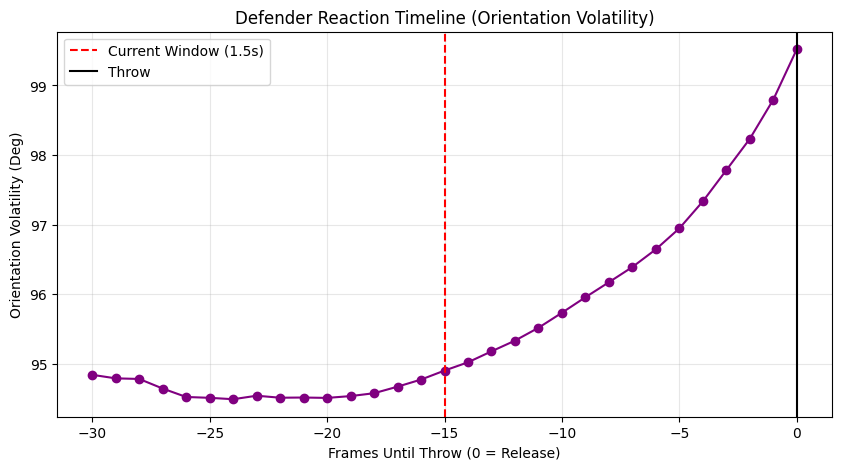

Avg Volatility (Early Drop): 94.62
Avg Volatility (Final 1.5s): 96.59
✅ CONFIRMED: Defender activity spikes in the final 1.5s.
   (The window correctly captures the 'Action' phase)


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def validate_pre_throw_window(df):
    print("\n--- 🧪 PRE-THROW WINDOW VALIDATION ---")
    
    # 1. Prepare Pre-Throw Data
    # We only want the seconds leading up to the pass
    pre_throw = df[df['phase'] == 'pre_throw'].copy()
    
    # Calculate "Frames Until Throw" (Reverse index)
    # 0 = Moment of Throw, -10 = 1 second before, etc.
    throw_frames = pre_throw.groupby(['game_id', 'play_id'])['frame_id'].max()
    pre_throw = pre_throw.merge(throw_frames.rename('throw_frame'), on=['game_id', 'play_id'])
    pre_throw['frames_until_throw'] = pre_throw['frame_id'] - pre_throw['throw_frame']
    
    # Filter to relevant window (e.g., last 3 seconds)
    window_df = pre_throw[pre_throw['frames_until_throw'] >= -30]
    
    # 2. Calculate Volatility (Standard Deviation of Orientation)
    # High Std Dev = Defenders are turning hips/reacting.
    # Low Std Dev = Defenders are backpedaling/static.
    volatility_profile = window_df.groupby('frames_until_throw')['o'].std()
    
    # 3. Plot
    plt.figure(figsize=(10, 5))
    plt.plot(volatility_profile.index, volatility_profile.values, marker='o', color='purple')
    
    # Mark the proposed cutoff
    plt.axvline(-15, color='r', linestyle='--', label='Current Window (1.5s)')
    plt.axvline(0, color='black', linestyle='-', label='Throw')
    
    plt.title("Defender Reaction Timeline (Orientation Volatility)")
    plt.xlabel("Frames Until Throw (0 = Release)")
    plt.ylabel("Orientation Volatility (Deg)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 4. Quantitative Check
    # Compare variance in the "Deep Drop" (-30 to -15) vs "Manipulation Zone" (-15 to 0)
    var_early = volatility_profile.loc[-30:-16].mean()
    var_late = volatility_profile.loc[-15:0].mean()
    
    print(f"Avg Volatility (Early Drop): {var_early:.2f}")
    print(f"Avg Volatility (Final 1.5s): {var_late:.2f}")
    
    if var_late > var_early:
        print("✅ CONFIRMED: Defender activity spikes in the final 1.5s.")
        print("   (The window correctly captures the 'Action' phase)")
    else:
        print("⚠️ WARNING: No distinct volatility spike.")
        print("   (Consider widening the window to -20 or -25)")

# Run validation
validate_pre_throw_window(df)

In [5]:
# ==========================================
# 10. SENSITIVITY ANALYSIS (STRESS TEST)
# ==========================================
# GOAL: Prove the results aren't fragile. 
# Does the "Panic Advantage" exist across different definitions?

def run_sensitivity_analysis(df):
    print("\n--- SENSITIVITY ANALYSIS ---")
    print(df.size)
    # Clean data like before
    df = df.dropna(subset=['bia_efficiency', 'pass_result'])
    df['is_complete'] = (df['pass_result'].astype(str).str.strip() == 'C').astype(int)
    print(df.size)
    # -----------------------------------------------------
    # TEST 1: THRESHOLD STABILITY (Impact on Completion %)
    # -----------------------------------------------------
    # We test thresholds from -0.8 (Running away) to 0.8 (Running well)
    thresholds = np.linspace(-0.8, 0.8, 20)
    deltas = []
    p_values = []
    
    for t in thresholds:
        # Define Panic as "Efficiency < t"
        panic_group = df[df['bia_efficiency'] < t]
        composed_group = df[df['bia_efficiency'] >= t]
        
        if len(panic_group) > 50 and len(composed_group) > 50:
            rate_p = panic_group['is_complete'].mean()
            rate_c = composed_group['is_complete'].mean()
            delta = rate_p - rate_c
            
            _, p = stats.ttest_ind(panic_group['is_complete'], composed_group['is_complete'])
            
            deltas.append(delta * 100)
            p_values.append(p)
        else:
            deltas.append(np.nan)
            p_values.append(np.nan)
            
    # PLOT RESULTS
    plt.figure(figsize=(10, 5))
    
    # Plot Delta
    plt.plot(thresholds, deltas, 'b-o', label='Completion % Lift')
    plt.axhline(0, color='black', linestyle='-', linewidth=1)
    
    # Shade significant area (p < 0.05)
    sig_mask = np.array(p_values) < 0.05
    # Just simplistic shading for visual
    for i, is_sig in enumerate(sig_mask):
        if is_sig and not np.isnan(deltas[i]):
            plt.plot(thresholds[i], deltas[i], 'ro') # Red dot = Significant
            
    plt.title("Robustness Check: Does Panic ALWAYS predict Completions?")
    plt.xlabel("Efficiency Threshold (Lower = Stricter Definition of Panic)")
    plt.ylabel("Increase in Completion %")
    plt.legend(["Completion % Delta", "Statistically Significant"])
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # -----------------------------------------------------
    # TEST 2: RANKING STABILITY (Who are the Victims?)
    # -----------------------------------------------------
    print("\n>>> RANKING STABILITY CHECK")
    # Compare "Mean Efficiency" (Your App) vs "Frequency of Severe Panic" (Alternative)
    
    # A. Rank by Mean Panic Score (The App's Method)
    rank_mean = df.groupby('player_name')['bia_efficiency'].mean().sort_values().head(20).index.tolist()
    
    # B. Rank by "Disaster Rate" (% of plays with Eff < -0.5)
    def disaster_rate(x):
        return (x < -0.5).mean()
        
    rank_freq = df.groupby('player_name')['bia_efficiency'].agg(disaster_rate).sort_values(ascending=False).head(20).index.tolist()
    
    # Calculate Overlap
    common = set(rank_mean).intersection(rank_freq)
    overlap_pct = len(common) / 20 * 100
    
    print(f"Top 20 Victims Overlap (Mean vs. Frequency): {overlap_pct:.0f}%")
    print(f"Consistent Victims: {list(common)[:5]}...")
    
    if overlap_pct > 60:
        print("✅ PASSED: Rankings are stable regardless of aggregation method.")
    else:
        print("⚠️ WARNING: Rankings depend heavily on the definition.")

results_path = '../src/clv_data_export.csv'
    
    

df = pd.read_csv(results_path)
print(df.head())
run_sensitivity_analysis(df)

FileNotFoundError: [Errno 2] No such file or directory: '../src/clv_data_export.csv'

In [6]:
# Load the processed master file
file_path = '../data/supplementary_data.csv'
print(f"Loading {file_path}...")
df = pd.read_csv(file_path, low_memory=False)

Loading ../data/supplementary_data.csv...


In [15]:
df.head(10)

,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
0,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3461,(10:46) (Shotgun) J.Goff pass deep left to J.R...,4,...,COVER_2_ZONE,NaN,18,18,-0.664416,2.945847,0.834296,0.165704,-0.081149,0.081149
1,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,461,(7:30) J.Goff pass short right to J.Reynolds t...,1,...,COVER_6_ZONE,NaN,21,21,1.926131,1.345633,0.544618,0.455382,-0.029415,0.029415
2,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1940,(:09) (Shotgun) J.Goff pass incomplete deep ri...,2,...,COVER_2_ZONE,NaN,0,0,0.281891,-0.081964,0.771994,0.228006,0.000791,-0.000791
3,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1711,"(:45) (No Huddle, Shotgun) P.Mahomes pass deep...",2,...,COVER_2_ZONE,NaN,26,26,3.452352,2.342947,0.663187,0.336813,0.041843,-0.041843
4,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1588,(1:54) (Shotgun) P.Mahomes pass incomplete dee...,2,...,COVER_4_ZONE,NaN,0,0,1.921525,-0.324035,0.615035,0.384965,0.000061,-0.000061
5,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,101,(14:25) (Shotgun) J.Goff pass incomplete deep ...,1,...,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.049720,-0.049720
6,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3566,(8:31) J.Goff pass short right to J.Reynolds t...,4,...,COVER_1_MAN,NaN,33,33,2.974547,2.122270,0.739288,0.260712,-0.099454,0.099454
7,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,902,(13:54) (Shotgun) P.Mahomes pass incomplete sh...,2,...,COVER_1_MAN,NaN,0,0,4.405786,-0.407670,0.490896,0.509104,-0.011206,0.011206
8,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1069,(11:50) J.Goff pass short middle to B.Wright t...,2,...,COVER_3_ZONE,NaN,9,9,1.347074,0.566854,0.554222,0.445778,-0.016984,0.016984
9,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,2261,(12:31) (Shotgun) J.Goff pass short left to S....,3,...,COVER_1_MAN,NaN,4,4,-1.290895,-1.334247,0.833186,0.166814,0.020599,-0.020599


In [20]:
num_unique_plays = df.drop_duplicates(subset=['game_id', 'play_id']).shape[0]

In [28]:
df[df["dropback_type"] != "TRADITIONAL"]["dropback_type"]

10       DESIGNED_ROLLOUT_RIGHT
11                     SCRAMBLE
17       SCRAMBLE_ROLLOUT_RIGHT
27                     SCRAMBLE
29       DESIGNED_ROLLOUT_RIGHT
                  ...          
17934                  SCRAMBLE
17940                  SCRAMBLE
17941     DESIGNED_ROLLOUT_LEFT
17967     DESIGNED_ROLLOUT_LEFT
17970     DESIGNED_ROLLOUT_LEFT
Name: dropback_type, Length: 2087, dtype: object

In [33]:
df["defenders_in_the_box"]

0        6
1        7
2        6
3        5
4        6
        ..
18004    6
18005    6
18006    7
18007    5
18008    5
Name: defenders_in_the_box, Length: 18009, dtype: int64

In [32]:
df[df["pass_location_type"] != "INSIDE_BOX"]["pass_location_type"]

10       OUTSIDE_RIGHT
11       OUTSIDE_RIGHT
16       OUTSIDE_RIGHT
17       OUTSIDE_RIGHT
27        OUTSIDE_LEFT
             ...      
17923     OUTSIDE_LEFT
17934    OUTSIDE_RIGHT
17940    OUTSIDE_RIGHT
17941     OUTSIDE_LEFT
17967     OUTSIDE_LEFT
Name: pass_location_type, Length: 2055, dtype: object